In [37]:
import tensorflow as tf
import tensorflow_probability.python.distributions as tfdist
import tensorflow_probability as tfp
# tfdist./
bkd = tfdist
sess = tf.InteractiveSession()
# bkd.Mixture?`

[WARN]unable to import edward.models


[WARN]unable to import edward.models


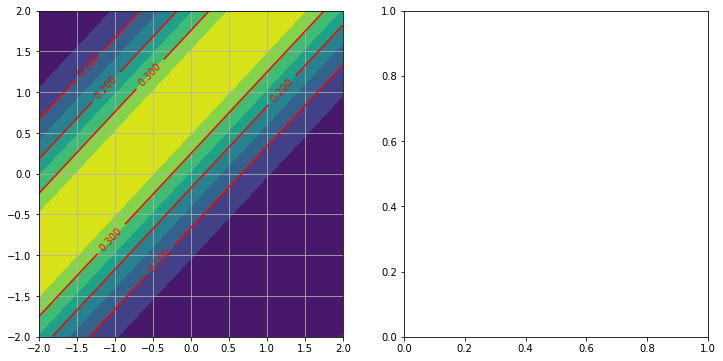

In [56]:
import pymisca.tensorflow_extra_.gaussian_field as mod;reload(mod)

# import pymisca.tensorflow_extra as pytf;reload(pytf)
import pymisca.tensorflow_extra as pytf;reload(pytf)
import numpy as np

loc = range(1,2)
sigma = range(1,2)
dist = pytf.GaussianField(loc=loc,scale=sigma,D=2)

import pymisca.util as pyutil
import pymisca.vis_util as pyvis
f = dist.prob
f = pyutil.wrapTFmethod(f)
f = pyutil.arrayFunc2mgridFunc(f)
pyvis.dmet_2d(f=f,vectorised=1);

# dist.prob(np.random.random(size=(100,3)).astype('float32'))

In [4]:
import numpy as np

In [17]:
# ??tfdist.fill_triangular_inverse

In [23]:
tfdist.fill_triangular_inverse(
    [[1, 2, 3],
     [0, 5, 6],
     [0, 0, 4]], upper=True).eval()

array([1, 2, 3, 5, 6, 7], dtype=int32)

In [29]:
import numpy as np
d = 3
ul = np.tril_indices(d,-1)

In [24]:
??tfdist.fill_triangular_inverse

In [79]:
tf.range(X.shape[0])

<tf.Tensor 'range_1:0' shape=(3,) dtype=int32>

In [82]:
?itertools.combinations

In [84]:
tf.range(X.shape[0]).eval()

array([0, 1, 2], dtype=int32)

In [107]:
sp = tf.TensorShape([2,4])
sp.
# sp.merge_with(b.shape)
# sp.concatenate(b.shape,)
# tf.shape(b)

ValueError: Shapes (2, 4) and (4,) are not compatible

In [116]:
ul

((-1,), array([1, 2, 2]), array([0, 0, 1]))

In [132]:
print 1

1


In [161]:
? np.tril_indices

In [ ]:
t

In [172]:
?tf.transpose

In [181]:
import tensorflow.contrib.framework
# tf.ran
# tensorflow.contrib.framework.argsort(axes)

array([0, 1, 2], dtype=int32)

In [198]:
?tf.transpose

In [203]:
X = np.reshape(range(9),[3,3])
print (X)
# X.take(ul,axis=(0,1))
# print (X.reshape())
# tf.shape
X = tf.convert_to_tensor(X)
X = tf.tile(X[None],[10,1,1])
#### (batch,a,b) -> (b,a,batch)
Y = tf.transpose(X)

def wrapper_perm(f,perm=None,iperm = None):
#     if perm is not None:
#         iperm = np.argsort(perm)
#     else:
#         iperm = perm
    def g(X,*args,**kwargs):
            
        X = tf.transpose(X,perm=perm)
        Y = f(X,*args,**kwargs)
        Y = tf.transpose(Y,perm=iperm)
        return Y
    return g
def take_tril(X,n,k=-1,m=None, transpose=False,):
    '''
    Take tril of the first two dimensions
'''
#     wrapper__perm()
    ul = np.tril_indices(n,-1)
    ulzip = zip(*(ul))
    if transpose:
        ul = ul[::-1]
    Y = tf.gather_nd(X,zip(*(ul))).eval()
    return Y
pytf.take_tril = take_tril
pytf.wrapper_perm = wrapper_perm
import functools

##### Take low triangle of d*d matrix along axes=(1,2)
npd = d * (d - 1) / 2
f = functools.partial(pytf.take_tril, 
                      n = d, k=-1,transpose=False)
Y = pytf.wrapper_perm(f,perm=(1,2,0),iperm=(1,0))(X)
# print d * (d - 1) / 2

print(Y.eval())

# tf.gather_nd(X,[[0]]).eval()

# tf.gather(X,zip(*ul)).eval()
# tf.gather(X,ul).eval()
# tf.gather(tf.reshape(X,[1,-1])[:,ul_flat]
# .eval()
# tf.Tensor(X)
# tfdist.fill_triangular_inverse(,upper=True).eval()

[[0 1 2]
 [3 4 5]
 [6 7 8]]
3
[[3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]
 [3 6 7]]


In [69]:
import pymisca.tensorflow_extra_.gaussian_affine_field as mod

In [66]:
%%writefile ~/repos/pymisca/pymisca/tensorflow_extra_/gaussian_affine_field.py

import tensorflow_probability as tfp
import tensorflow_probability.python.distributions as tfdist
import pymisca.tensorflow_extra as pytf
ed = edm = pytf.ed
tf = pytf.tf;

import pymisca.util as pyutil
np = pyutil.np

from pymisca.models import BaseModel

import tensorflow_probability.python.bijectors as tfbjt

bkd = tfdist
class GaussianAffineField__VIMAP(BaseModel):
    bkd    = tfdist
    emDist = tfdist.Normal
    
    em_key =[
        'loc',
        'scale',
        ]
    mix_key = [
            'mix_x',
            'mix_y'
        ]
    
    def __init__(self,D=None,K=20,
                 debug=False,NCORE=1,alpha = None,
                 ncatx = 1,
                 ncaty = 1,
                 mode = 'left',
                 diri = 1,
                 transpose=0,
                 *args,**kwargs):
        super(
            GaussianAffineField__VIMAP,
            self).__init__(*args,**kwargs)
        self.NCORE= NCORE
        self.K = K
        self.D = D
        self.initialised = False
        self.sess = None
        self.feed_dict = None
        self.debug = debug
        self.alpha = 0.1 if alpha is None else alpha
        self.ncaty = self.ncatx = ncatx
        self.mode = mode
        self.diri = diri
        self.transpose= transpose
#         self.ncatx = ncatx
#         self.ncaty = ncaty
        if D is not None and not debug:
            self.init_model(D=D)  
            
#     def __init__(self,D=None,K = None,alpha = 1.0):
    def init_model(self,D=None,K = None,alpha = 1.0):
        if self.initialised:
            return self
        prior = self.make_prior()
        post = self.make_post()
        ##### Dictonary for constructing self.emDist(**self.param)
        self.param_key = (self.em_key + 
                          self.mix_key)

        self.initialised = True; 
        return self
    
    def make_prior(self):
        self.alpha = 1.
        ncatx,ncaty = self.ncatx,self.ncaty
        if self.debug:
            print ('[making prior]')
        self.prior = prior = pyutil.util_obj()        
        
        return prior
    
    def make_post(self):
        D = self.D
        K = self.K
        ncatx,ncaty = self.ncatx,self.ncaty
#         alpha = self.D/2.
    #     name = 'test'
        self.post = post = pyutil.util_obj()
        self.postScope = self.get_variable_scope('post')
        
        return post       

    def make_mixture(self,X=None,env=None):
    #     K = self.K
#         N = len(X)    
        d = D = self.D
        npd = d * (d - 1) / 2  ### size after taking tril
        

        shape = X.shape
#         env = self.get_env(env)
        env = post = self.post
        prior = self.prior 
        ncaty = self.ncaty
        ncatx = self.ncatx
        
        self.postScope = self.get_variable_scope('mixed')
        
        with self.postScope:       

            post.loc = ( tf.get_variable(shape=(npd,),name='loc') 
                                       )            
            post.scale = tf.nn.softplus( tf.get_variable(shape=(npd,),name='scale') 
                                       )            
#             post.scale = scale  
#             post.scale = tf.abs(post.loc)  
#         * tf.ones(shape=(ncatx,ncaty))
            dist = pytf.GaussianField(loc= post.loc,
                                      
                                      scale=post.scale,
                                      D=self.D)
            env.emission = dist
        
        return env.emission
    
    def get_variable_scope(self,ext, name=None):
        if name is None:
            name = self.name
        scope_name = name+'/%s'%ext
        try:
            tf.get_variable(scope_name,[1])
            reuse = None
        except:
            reuse = True
        print ('reuse',reuse)
        scope = tf.variable_scope(scope_name, reuse=reuse)
        return scope
    
    def get_env(self,env=None):
        if env is None:
            env = self.prior
        elif isinstance(env,str):
            env = getattr(self,env)
        return env
    
    def _fit(self,X, 
             n_iter = 1000, 
             n_print=100, 
             env=None,
             optimizer = None, 
             **kwargs):
        
        K = self.K
        N = len(X)
#         emission = self.build_likelihood(X,env=env)
        self.init_model()
    
        mdl, (last_vars, hist_loss, opt) = self._fit_MAP(
            X,
            MAX_ITER = n_iter,
            optimizer = optimizer,
            **kwargs)
        
        return hist_loss
        
#     _class = matrixDecomp__VIMAP





# _class.build_likelihood = make_mixture


    def _fit_MAP(self,x_obs, optimizer = None, **kwargs):
        self.init_model()
        mdl = self.make_mixture(X=x_obs,env='post')
        x_place = tf.placeholder(shape=x_obs.shape,dtype='float32')

        ### prior likelihood
        self.lp_param = lp_param = [
            tf.reduce_sum(
                prv.log_prob(self.post[k])  ### ed.RandomVariable.value()
            ) 
            if prv.__class__.__name__ != 'Uniform' 
            else 0.
            for k,prv in self.prior.__dict__.items()]
    #         print (tf.reduce_sum(lp_param))
    
        ### data likelihood
        self.lp_data = lp_data = tf.reduce_sum(
            mdl.log_prob(x_place)
        )
        lp = tf.reduce_sum(
            map(tf.reduce_sum,[
                lp_param,
                lp_data])
        )
        loss = -lp
    #         loss = 0.
    #         loss += tf.reduce_sum(-lp_param) + tf.reduce_sum()s

        self.feed_dict = {x_place:x_obs}
    #         fitted_vars_dict = {k:x.value() for k,x in 
    #                        self.post.__dict__.iteritems() 
    #                        if not isinstance(x,list) and k in self.param_key}
        self.sess = pytf.newSession(NCORE=self.NCORE)

#         tf.global_variables_initializer().run()
        
        sess, last_vars, hist_loss, opt = pytf.op_minimise(
            loss,
            self.freeVarDict('post').values(),
            optimizer = optimizer,
            feed_dict = self.feed_dict,
            sess = self.sess,
            **kwargs

        )
    #         self.sess = sess
        return mdl,(last_vars, hist_loss, opt)

    def freeVarDict(self, env):
        if isinstance(env,dict):
            idict = env
        else:
            if isinstance(env,str):
                env = getattr(self,env)
            else:
                raise Exception('"env" not recognised:%s'%env)
            idict = env.__dict__
        odict = {k:
#                  x.value() ### for edward.PointMass()
                 x
                 for k,x in 
                       idict.iteritems() 
                       if not isinstance(x,list) and k in self.param_key}            
        return odict
    
main = GaussianAffineField__VIMAP

Overwriting /home/feng/repos/pymisca/pymisca/tensorflow_extra_/gaussian_affine_field.py


In [59]:
# ?tf.placeholder